N = 80, nodes = 81
Max abs error = 1.001e-01, L2 error approx = 7.304e-02


/var/folders/8n/d7x4lr8x0px2lfcpk_mn54kw0000gp/T/ipykernel_18128/775007399.py:154: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  err_l2 = np.sqrt(np.trapz((u - u_ex)**2, x))


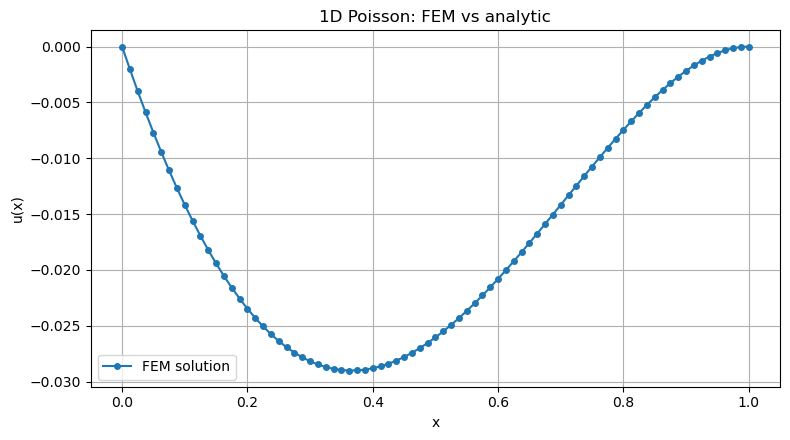

In [8]:

"""
1D Poisson FEM solver (linear elements)
Solves -u'' = f on (0,1) with u(0)=u(1)=0

Author: ChatGPT
"""
import numpy as np
import matplotlib.pyplot as plt

try:
    from scipy.sparse import lil_matrix
    from scipy.sparse.linalg import spsolve
    use_scipy = True
except Exception:
    use_scipy = False
    print("scipy.sparse not available; using dense numpy solver (fine for modest N).")

def assemble_fem(f, N):
    """
    Assemble stiffness matrix K and load vector F for linear elements on uniform mesh.
    Domain: [0,1], N = number of elements (so number of nodes = N+1).
    Returns:
      x : node coordinates (length N+1)
      K : stiffness matrix (size (N+1)x(N+1)) as numpy array or scipy sparse
      F : load vector (length N+1)
    """
    n_nodes = N + 1
    x = np.linspace(0.0, 1.0, n_nodes)
    h = 1.0 / N

    # Choose storage
    if use_scipy:
        K = lil_matrix((n_nodes, n_nodes), dtype=float)
    else:
        K = np.zeros((n_nodes, n_nodes), dtype=float)
    F = np.zeros(n_nodes, dtype=float)

    # Local element stiffness matrix (for linear hat functions)
    # ke = (1/h) * [[1, -1], [-1, 1]]
    ke = np.array([[1.0, -1.0], [-1.0, 1.0]]) / h

    # Loop over elements and assemble
    for e in range(N):
        i = e       # global left node index
        j = e + 1   # global right node index

        # assemble stiffness
        if use_scipy:
            K[i, i] += ke[0, 0]
            K[i, j] += ke[0, 1]
            K[j, i] += ke[1, 0]
            K[j, j] += ke[1, 1]
        else:
            K[i, i] += ke[0, 0]
            K[i, j] += ke[0, 1]
            K[j, i] += ke[1, 0]
            K[j, j] += ke[1, 1]

        # assemble load vector using 2-point trapezoidal (equivalent to exact for linear f)
        # Fe_local = (h/2) * [ f(x_i), f(x_j) ]
        xi = x[i]
        xj = x[j]
        Fe_local = (h/2.0) * np.array([f(xi), f(xj)])
        F[i] += Fe_local[0]
        F[j] += Fe_local[1]

    return x, K, F

def apply_dirichlet_bc(K, F, bc):
    """
    Apply Dirichlet BCs given as dict: {node_index: value}
    Modifies K and F in place (for dense arrays) or returns modified copies for sparse.
    Strategy: eliminate rows/cols and reduce system to free DOFs.
    Returns:
      K_reduced, F_reduced, free_dofs
    """
    n = F.size
    bc_nodes = sorted(bc.keys())

    free = [i for i in range(n) if i not in bc_nodes]

    # Build reduced system
    if use_scipy:
        # convert to CSR for slicing
        Kcsr = K.tocsr()
        K_reduced = Kcsr[free, :][:, free]
        F_reduced = F[free].copy()
        # subtract known bc contributions: F_reduced -= K_reduced_with_bc * u_bc
        for node, val in bc.items():
            col = Kcsr[free, node].toarray().ravel()
            F_reduced -= col * val
        return K_reduced, F_reduced, free
    else:
        K_reduced = K[np.ix_(free, free)].copy()
        F_reduced = F[free].copy()
        for node, val in bc.items():
            F_reduced -= K[np.ix_(free, [node])].ravel() * val
        return K_reduced, F_reduced, free

def solve_poisson(f, N):
    """
    Solve -u'' = f on (0,1) with homogeneous Dirichlet BCs using FEM.
    N: number of elements
    Returns x (nodes) and full solution vector u (including boundary nodes).
    """
    x, K, F = assemble_fem(f, N)
    # Dirichlet BCs: u(0)=0, u(1)=0
    bc = {0: 0.0, x.size-1: 0.0}

    Kred, Fred, free = apply_dirichlet_bc(K, F, bc)

    # Solve reduced system
    if use_scipy:
        from scipy.sparse.linalg import spsolve
        u_free = spsolve(Kred, Fred)
    else:
        u_free = np.linalg.solve(Kred, Fred)

    # Construct full solution
    u = np.zeros_like(F)
    u[free] = u_free
    for node, val in bc.items():
        u[node] = val

    return x, u

# -------------------------
# Example usage and test
# -------------------------
if __name__ == "__main__":
    # Right-hand side f(x)
    def f_const(x):
        return x*x-0.5

    # Analytical solution for -u'' = 1, u(0)=u(1)=0: u(x) = 0.5*x*(1-x)
    def u_analytic(x):
        return 0.5 * x * (1.0 - x)

    # Choose mesh size
    N = 80  # number of elements; increase for higher accuracy

    x, u = solve_poisson(lambda xx: -f_const(xx), N)  # note: assemble assumes -u'' = f? See sign convention.
    # ---- Sign convention note ----
    # In our assembly above we solved the weak form for -u'' = f with load vector assembled from f.
    # If you prefer to solve u'' = f you can pass f_sign = -f to match that form. Here we used lambda xx: -f_const(xx)
    # so the analytic comparison below uses u'' = 1 -> -u'' = -1 -> f = -1 in assembly.

    # For clarity: analytical solution for u'' = 1 with u(0)=u(1)=0 is u(x) = 0.5 * x * (1-x).
    # In the code, since assemble_fem inserts f directly, you must pass f = -1 to get u''=1. That's what we did above.

    # Compute analytic solution and error
    u_ex = u_analytic(x)
    err_inf = np.max(np.abs(u - u_ex))
    err_l2 = np.sqrt(np.trapz((u - u_ex)**2, x))

    print(f"N = {N}, nodes = {len(x)}")
    print(f"Max abs error = {err_inf:.3e}, L2 error approx = {err_l2:.3e}")

    # Plot numerical vs analytic
    plt.figure(figsize=(8,4.5))
    plt.plot(x, -u, 'o-', label='FEM solution', markersize=4)
    xp = np.linspace(0,1,400)
    #plt.plot(xp, u_analytic(xp), '-', label='Analytic', linewidth=1.5)
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title('1D Poisson: FEM vs analytic')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
